# Third party commercial data

The aim of this notebook is to guide you how to get Very High Resolution Satellite (VHRS) data using Sentinelhub and eo-learn. Price for commercial data is described there https://www.sentinel-hub.com/pricing/.

The workflow for agriculture purposes is as follows :

1) Read shapefile that represent you field (boundaries or microplots)

2) Extract Sentinel-2 data and compute averaged NDVI time series to get a summary of the season vegetation dynamic.

3) Get the index of time when NDVI is maximum (season's peak) and add +/- one month to this date to get the time period for VHRS data extraction.

4) Extract VHRS data. If provider is Airbus, you can apply pansharpening algorithms to get the spatial resolution from the panchromatic band.

5) Preprocess and save the data.

6) Optional : intersects pixels with trial microplots polygons to get a value of NDVI for each microplot.

## Set your working environment

### Import the packages

In [23]:
import warnings
warnings.filterwarnings("ignore")

import glob
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

from eocrops.input import utils_sh as utils_sh
from eocrops.input import sentinel2 as sentinel2
from eocrops.input import vhrs as vhrs
from eocrops.tasks import preprocessing as preprocessing
from eocrops.tasks import vegetation_indices
from eolearn.io import ExportToTiffTask
from eolearn.core import FeatureType
vhrs = reload(vhrs)
vegetation_indices = reload(vegetation_indices)

### Read your vector file

In [2]:
dir_path = os.path.dirname(os.getcwd())
print(dir_path)
#read microplot data
shapefile_input = gpd.read_file(os.path.join(dir_path, './examples/layers/POLYGON.shp'))

/home/johann/Documents/git-repo/eo-crops


In [3]:
api = ''
client_id = ''
client_secret = ''
config = utils_sh.config_sentinelhub_cred(api, client_id, client_secret)
# Provide here your planet API key
config.planet_key = ''

### Extract S2 data

In [4]:
time_period = ('2020-02-01', '2020-10-30')
kwargs = dict(polygon=shapefile_input,
              time_stamp=time_period,
              config=config)

In [5]:
patch = sentinel2.workflow_instructions_S2L2A(**kwargs,
                                              coverage_predicate=0.5,
                                              interpolation={'interpolate' : True})  # you can add period_length in the dictionary to resample pixel wise


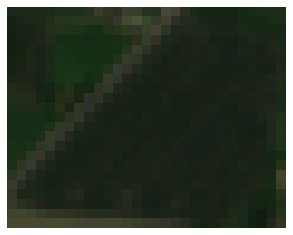

In [6]:
#RGB
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(patch.data['BANDS-S2-L2A'][15][..., [2, 1, 0]]*2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);
plt.show()

In [7]:
#Mask out pixels that are oustide the polygon for visualisation and apply a binary erosion with radius = 1 to keep only pure pixels
masking = preprocessing.MaskPixels(["NDVI"])
patch = masking.execute(patch, erosion = 1)

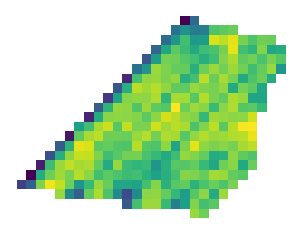

In [8]:
#NDVI
plt.figure(figsize=(5, 5))
plt.imshow(patch.data['NDVI'][15].squeeze());
plt.axis(False);
plt.show()

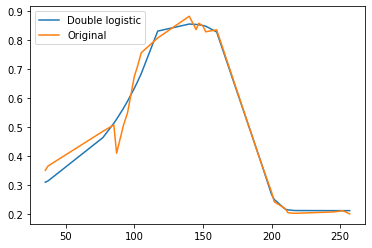

In [53]:
#NDVI Time Series from masked field
variable = 'NDVI'
#Subset the time series between doy 30 and 260 => useful for double logistic smoothing
curve_fit = preprocessing.CurveFitting(range_doy=(30, 260))
doy, _ = curve_fit.get_doy_period(patch)

ts_mean = curve_fit.get_time_series_profile(patch,feature=variable, feature_mask = 'MASK').flatten()
fitted = curve_fit.execute(patch, feature=variable, feature_mask = 'MASK')

plt.plot(doy, fitted,  label='Double logistic')
plt.plot(doy, ts_mean, label='Original')
plt.legend(loc='upper left')
plt.show()

In [54]:
#Parameters from doubly logistic 
#α1 is seasonal minimum greenness
#α2 is the seasonal amplitude
#α3 controls the green-up rate
#α4 is the green-up inflection point
#α5 controls the mid-growing season greenness trajectory.

curve_fit.params[2:]

array([0.37726922, 0.3147344 , 5.91591333, 0.20032278, 1.        ])

In [10]:
#Peak of the season is at 15/05 
time_max_index = np.nanargmax(fitted)
patch.timestamp[time_max_index]

datetime.datetime(2020, 5, 26, 11, 17, 45)

In [15]:
#If oyu would like to save the data in .tif format (e.g. NDVI on the first date)
index_time = 0
date = str(patch.timestamp[index_time]).split(' ')[0]

export = ExportToTiffTask(feature=(FeatureType.DATA, 'NDVI'),
                          folder=os.path.join('your_path_'+ date),
                          band_indices=[0],
                          date_indices=[index_time])
patch = export.execute(patch)

## VHRS data

In [57]:
#Define the time period
time_period_vhrs = ('2020-04-15', '2020-06-15')
#Define the workflow
download_workflow = vhrs.DownloadVHRSSentinelHub(shapefile=shapefile_input,
                                                 time_stamp = time_period_vhrs,
                                                 config = config,
                                                 maxCloudCoverage=10)

### Extract Planetscope data

You can retrieve order id and collection ID on your SH account (https://apps.sentinel-hub.com/dashboard/#/tpdi) 

Instead of doing a request again, you can go directly on *download_workflow.get_data* using the following ids :

**order_id** = '2f900fad-1f5e-4a46-b6da-327012d400e1'

**collection_id** = '79a1a2a9-ccf8-4e1f-8f42-9d854bf1dca9'

In [58]:
#Define the provider as follows for Planetscope
provider_planet = ('PLANET', 'PSScene4Band')

In [59]:
#Define the workflow to get your order_id and collection_id. It can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi
order_id, results = download_workflow.execute_query(provider_planet, name_query='Example Planet')

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"c7d9ea4c-c797-40d4-9566-586774d82016","exp":1659969220,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"9d2e0eda-1a03-4aee-9887-c728a31947f3","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'
353e6fee-76d2-40e9-82d8-da90b13f9c13
1.4870982763449545
CREATED


In [60]:
#You can access to all the meta data in results.
len(results['features'])

24

In [61]:
#Check the status of the order. Image will not be available 
collection_id = download_workflow.confirm_order(order_id)

RUNNING


In [64]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. 
#The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id)

b'{"sub":"6c2887da-a213-462e-a10c-fcb94e066dc9","aud":"07ae5fb1-ea68-4da0-9574-ea6978ead834","jti":"c385bb4c-343a-4069-ae91-5ebba7dd84b4","exp":1659969261,"name":" ","email":"johann.desloires@inrae.fr","given_name":"","family_name":"","sid":"87f697e7-2e19-4479-98e1-850b7a8a9ada","org":"3d31397f-770a-4f98-9358-84e918491745","did":1,"aid":"8f176e67-7f79-41d7-afae-901872621c07","d":{"1":{"ra":{"rag":7},"t":14001}},"active":true}'


'RUNNING'

In [25]:
#order_id = '2f900fad-1f5e-4a46-b6da-327012d400e1'
#collection_id = '79a1a2a9-ccf8-4e1f-8f42-9d854bf1dca9'
eopatch_planet = download_workflow.get_data(order_id = order_id,
                                            collection_id = collection_id,
                                            provider = provider_planet,
                                            resolution = 3)

In [26]:
#Reset the download_workflow if you would like to launch new orders. It is a way to prevent to download multiple times the same image and consume credits.
download_workflow.reset_workflow()

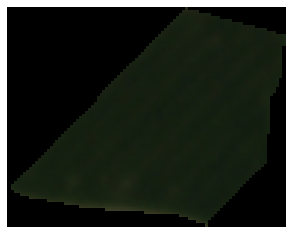

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_planet['data']['BANDS'][..., [2, 1, 0]][7,], 0, 1));
plt.axis(False);
plt.show()

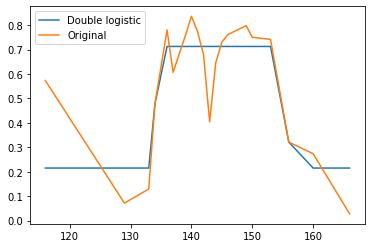

In [55]:
#NDVI Time Series from masked field
variable = 'NDVI'

curve_fit = preprocessing.CurveFitting(range_doy=(30, 260))
doy, _ = curve_fit.get_doy_period(eopatch_planet)

ts_mean = curve_fit.get_time_series_profile(eopatch_planet, feature=variable, feature_mask = 'MASK').flatten()
fitted = curve_fit.execute(eopatch_planet, feature=variable, feature_mask = 'MASK')

plt.plot(doy, fitted,  label='Double logistic')
plt.plot(doy, ts_mean, label='Original')
plt.legend(loc='upper left')
plt.show()

In [56]:
#Parameters from doubly logistic 
#α1 is seasonal minimum greenness
#α2 is the seasonal amplitude
#α3 controls the green-up rate
#α4 is the green-up inflection point
#α5 controls the mid-growing season greenness trajectory.

curve_fit.params[2:]

array([ 0.53688983,  0.26130331, 63.01277785,  0.17811609, 63.46261595])

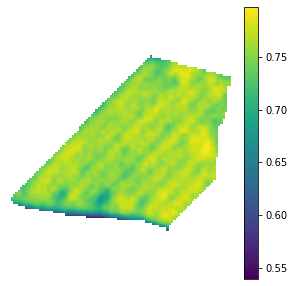

In [30]:
time_peak = np.nanargmax(fitted)
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_planet.data['NDVI'][time_peak,].astype(float))
plt.colorbar()
plt.axis(False);
plt.show()

If you would like to save the EOPatch, you can 
- call the method .save (e.g. eopatch_spot.save(your_path)) from your EOPatch to save the corresponding npys
- save .tif images using ExportToTiffTask from eo-learn https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiffTask

In [ ]:
#If you would like to save the data in .tif format (e.g. NDVI on the first date)
index_time = 0
date = str(eopatch_planet.timestamp[index_time]).split(' ')[0]

export = ExportToTiffTask(feature=(FeatureType.DATA, 'NDVI'),
                          folder=os.path.join('your_path_'+ date),
                          band_indices=[0],
                          date_indices=[index_time])
export.execute(eopatch_planet)

### Extract AIRBUS SPOT data

In [33]:
#Define the provider as follows for Planetscope
provider_spot = ('AIRBUS', 'SPOT')
#can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi

Instead of doing a request again, you can go directly on *download_workflow.get_data* using the following ids :

**order_id_spot** = '222331e9-d8d3-4e2f-959c-e292a665b214'

**collection_id_spot** = '6458a2f4-70fb-4986-bb90-1b3aeaeaca25'

In [ ]:
#Define the workflow to get your order_id and meta data.  
order_id_spot, results_spot = download_workflow.execute_query(provider_spot, name_query='example spot')

In [ ]:
collection_id_spot = download_workflow.confirm_order(order_id_spot)

In [ ]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id_spot)

In [36]:
#Apply pansharpenning method to project native bands (VIS + NIR) at 6m into the panchromatic resolution (1.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.

#order_id_spot, collection_id_spot = '222331e9-d8d3-4e2f-959c-e292a665b214', '6458a2f4-70fb-4986-bb90-1b3aeaeaca25'
eopatch_spot = download_workflow.get_data(order_id = order_id_spot,
                                          collection_id = collection_id_spot,
                                          provider = provider_spot,
                                          resolution = 1.5,
                                          pansharpen = True, #put false if you do not to apply OTB command
                                          otb_path='/home/johann/Documents/OTB-8.0.1-Linux64/bin')

2022-08-08 15:21:37 (INFO) Pansharpening: Default RAM limit for OTB is 256 MB
2022-08-08 15:21:37 (INFO) Pansharpening: GDAL maximum cache size is 781 MB
2022-08-08 15:21:37 (INFO) Pansharpening: OTB will use at most 8 threads
2022-08-08 15:21:37 (INFO): Loading metadata from official product
2022-08-08 15:21:37 (INFO): Loading metadata from official product
2022-08-08 15:21:37 (INFO) Pansharpening: Lmvm algorithm
2022-08-08 15:21:37 (INFO): Estimated memory for full processing: 1.38769MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2022-08-08 15:21:37 (INFO): File ./tempo/Pansharpened_20200415.tif will be written in 1 blocks of 191x151 pixels
Writing ./tempo/Pansharpened_20200415.tif...: 100% [**************************************************] (0s)
2022-08-08 15:21:37 (INFO) Pansharpening: Default RAM limit for OTB is 256 MB
2022-08-08 15:21:37 (INFO) Pansharpening: GDAL maximum cache size is 781 MB
2022-08-08 15:21:37 (INFO) Pansharpening: OTB will use at most 8 threads
20

In [37]:
#Reset the download_workflow method if you would like to execute new queries. 
# t is a way to prevent to download multiple times the same image and consume credits for nothing.
download_workflow.reset_workflow()

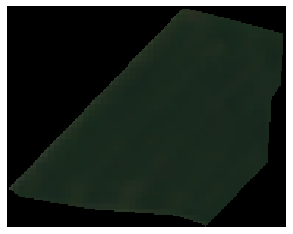

In [38]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_spot['data']['BANDS'][..., [2, 1, 0]][1,], 0, 1));
plt.axis(False);
plt.show()


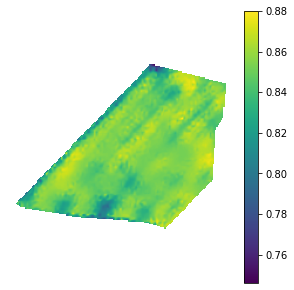

In [44]:
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_spot.data['NDVI'][1,].astype(float), vmax = 0.88)
plt.colorbar()
plt.axis(False);
plt.show()

### Extract AIRBUS Pleaides data

Airbus Pleiades have a Panchromatic band at 0.5m and VIS-NIR at 1.5m. On SH, the price is roughly 10€ for 1km2 of order, with a minimal order of 0.25km2 (2€50).

In [45]:
#Define the provider as follows for Planetscope
provider_pleaides = ('AIRBUS', 'PHR')

Instead of doing a request again, you can go directly on *download_workflow.get_data* using the following ids :

**order_id_pleiades** = 'e7f5c398-0d23-4f9d-a6a8-03b2b0632554'

**collection_id_pleaides** = '9eb3a890-7984-46bb-970d-db30ad5a4209'

In [ ]:
#Define the workflow to get your order_id and collection_id. It can be also be retrieved in your SH account in https://apps.sentinel-hub.com/dashboard/#/tpdi
order_id_pleiades, results_pleiades = download_workflow.execute_query(provider_pleaides, name_query='example pleaides')

In [ ]:
collection_id_pleaides = download_workflow.confirm_order(order_id_pleiades)

In [ ]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id_pleiades)


In [155]:
#While the statut is "RUNNING", you should wait that you data is ingested in your SH account. The output of this cell must be "DONE" before your get access to the data (~ 2-5 minutes)
download_workflow.check_status(order_id_pleiades)


RUNNING


In [48]:
#Apply pansharpenning method to project native bands (VIS + NIR) at 6m into the panchromatic resolution (1.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.
#order_id_pleiades, collection_id_pleaides = 'e7f5c398-0d23-4f9d-a6a8-03b2b0632554', '9eb3a890-7984-46bb-970d-db30ad5a4209'
eopatch_pleaides = download_workflow.get_data(order_id = order_id_pleiades,
                                          collection_id = collection_id_pleaides,
                                          provider = provider_pleaides,
                                          resolution = 0.5,
                                          pansharpen = True, #Apply pansharpenning method to project native bands (VIS + NIR) at 1.5m into the panchromatic resolution (0.5). You need to have OrfeoToolbox installed in your computer, available for free on https://www.orfeo-toolbox.org/CookBook/Installation.html.
                                          otb_path = '/home/johann/Documents/OTB-8.0.1-Linux64/bin')

2022-08-08 15:23:34 (INFO) Pansharpening: Default RAM limit for OTB is 256 MB
2022-08-08 15:23:34 (INFO) Pansharpening: GDAL maximum cache size is 781 MB
2022-08-08 15:23:34 (INFO) Pansharpening: OTB will use at most 8 threads
2022-08-08 15:23:34 (INFO): Loading metadata from official product
2022-08-08 15:23:34 (INFO): Loading metadata from official product
2022-08-08 15:23:34 (INFO) Pansharpening: Lmvm algorithm
2022-08-08 15:23:34 (INFO): Estimated memory for full processing: 13.6552MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2022-08-08 15:23:34 (INFO): File ./tempo/Pansharpened_20200606.tif will be written in 1 blocks of 572x452 pixels
Writing ./tempo/Pansharpened_20200606.tif...: 100% [**************************************************] (0s)


In [49]:
eopatch_pleaides.timestamp

[datetime.datetime(2020, 6, 6, 11, 21, 32, 600000)]

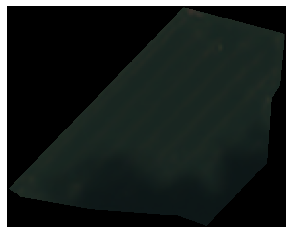

In [50]:
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(eopatch_pleaides['data']['BANDS'][..., [2, 1, 0]][0,], 0, 1));
plt.axis(False);
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


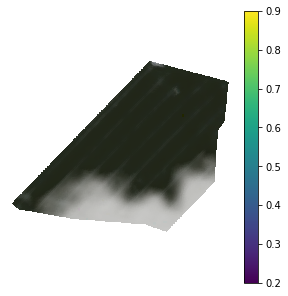

In [51]:
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_pleaides.data['BANDS-PAN'][0,].astype(float),vmin = 0.2, vmax = 0.9)
plt.colorbar()
plt.axis(False);
plt.show()

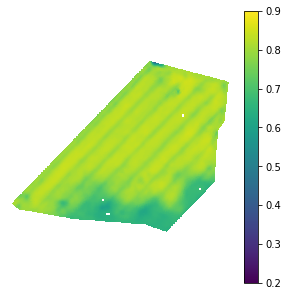

In [52]:
plt.figure(figsize=(5, 5))
plt.imshow(eopatch_pleaides.data['NDVI'][0,].astype(float),vmin = 0.2, vmax = 0.9)
plt.colorbar()
plt.axis(False);
plt.show()